In [327]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [328]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Union

import src.utils as utils

from src.dataloading import DataLoader
from src.preprocessing import Preprocesser
from src.vae_lstm import LSTMVAE
from src.vae_dense import DenseVAE, ImprovedDenseVAE
from src.vae_conv import ConvVAE

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import matplotlib
import tensorflow as tf
import mlflow

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

tf.keras.utils.set_random_seed(42)

# Define Hyperparams

In [329]:
# HYPERPARAMS
N_EPOCHS: int = 128
N_BATCHES: int = 4
VAL_SPLIT: float = 0.2
DROPOUT_RATE: float = 0.0                           # Only for DenseVAE
RECONSTRUCTION_WEIGHT: Union[float, int] = 5        # Weight of reconstruction_loss in total_loss metric

# Size of the latent dimension
LATENT_DIM: int = 64

# Settings to save model and history / comparison plots
SAVE_MODEL: bool = False     # If set to true, model will be saved under ../models/ dir
MODEL_ID: str = utils.get_model_id(N_EPOCHS, N_BATCHES, VAL_SPLIT, LATENT_DIM)

# Load Data

In [330]:
dataloader = DataLoader(path_to_data="../data/raw/P01")
df_list: list[pd.DataFrame] = dataloader.load_data()

2024-01-16 18:46:30,766 - src.dataloading - INFO - Found 10 .csv files in input path '../data/raw/P01' ...
2024-01-16 18:46:46,422 - src.dataloading - INFO - Parsed 10 .csv files into DataFrames ...


# Preprocess Data

In [331]:
CONDITIONS = ["MathxHard"] #["MathxEasy", "MathxMedium", "MathxHard"]
pp_data = {}

for i, condition in enumerate(CONDITIONS):
    preprocessor = Preprocesser(df_list=df_list, condition=condition, partition_size=250, fixed_size=11000)
    tensor: np.array = preprocessor.preprocess_data()
    FEATURE_NAMES = list(preprocessor.df_list_processed[0].columns)

    pp_data[condition] = {
        "tensor": tensor,
        "y_list": preprocessor.y_list_processed,
        "condition": condition,
        "condition_encoded": i,
        "condition_df": pd.DataFrame([condition for n in range(0, tensor.shape[0])]),
        "condition_encoded_df": pd.DataFrame([i for n in range(0, tensor.shape[0])]),
        "feature_names": FEATURE_NAMES,
        "scaler_object": preprocessor.scaler
    }


2024-01-16 18:46:46,683 - src.preprocessing - INFO - Starting preprocessing pipeline (Condition: MathxHard, Partition Size: 250, Fixed Size: 11000) ...
2024-01-16 18:46:46,838 - src.preprocessing - INFO - Stacking data to 3D tensor ...
2024-01-16 18:46:46,847 - src.preprocessing - INFO - Finished preprocessing pipeline (Duration: 0.16s) ...



In [332]:
# Stack data of each condition to one single 3D numpy array (input data to model)
tensor = np.concatenate([pp_data[key]["tensor"] for key in pp_data.keys()], axis=0)
y_tensor = np.concatenate([pp_data[key]["y_list"] for key in pp_data.keys()], axis=0)
conditions = pd.concat(pp_data[key]["condition_df"] for key in pp_data.keys())

In [333]:
# Get Labels in Shape (1290 x 1), i.e. (Number of Samples, Dimension_Label)
y_label_list = []
for i in range(0, y_tensor.shape[0]):
    y = y_tensor[i][0]
    y_label_list.append(y)
y_label = np.array(y_label_list)

# Discretize labels
def _discretize_target(val: float) -> np.array:
    """ Call this function via np.vectorize(_discretize_target)(y_label) """
    if val < 0.1:
        return 0
    elif 0.1 <= val < 0.3:
        return 1
    else:
        return 2

classes = np.vectorize(_discretize_target)(y_label)

In [334]:
print(f"Shape of Input Data: {tensor.shape}")
print(f"Shape of condition_df: {conditions.shape}")
print(f"Shape of Labels: {y_tensor.shape}")
print(f"Shape of discretized labels: {classes.shape}")

Shape of Input Data: (440, 250, 7)
Shape of condition_df: (440, 1)
Shape of Labels: (440, 250, 1)
Shape of discretized labels: (440, 1)


# Modelling

In [335]:
#vae = LSTMVAE(tensor=tensor, latent_dims=LATENT_DIM, reconstruction_weight=RECONSTRUCTION_WEIGHT)
#vae = DenseVAE(tensor=tensor, latent_dims=LATENT_DIM, reconstruction_weight=RECONSTRUCTION_WEIGHT, dropout_rate = DROPOUT_RATE, activation="relu")
vae = ImprovedDenseVAE(tensor=tensor, latent_dims=LATENT_DIM, reconstruction_weight=RECONSTRUCTION_WEIGHT, dropout_rate = DROPOUT_RATE)
#vae = ConvVAE(tensor=tensor, latent_dims=LATENT_DIM, reconstruction_weight=RECONSTRUCTION_WEIGHT)

vae.compile(optimizer="adam")
vae.build((None, tensor.shape[1], tensor.shape[2]))

In [336]:
vae.encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_23 (InputLayer)       [(None, 250, 7)]             0         []                            
                                                                                                  
 flatten_10 (Flatten)        (None, 1750)                 0         ['input_23[0][0]']            
                                                                                                  
 dense_98 (Dense)            (None, 512)                  896512    ['flatten_10[0][0]']          
                                                                                                  
 batch_normalization_52 (Ba  (None, 512)                  2048      ['dense_98[0][0]']            
 tchNormalization)                                                                          

In [337]:
vae.decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 64)]              0         
                                                                 
 dense_103 (Dense)           (None, 64)                4160      
                                                                 
 leaky_re_lu_61 (LeakyReLU)  (None, 64)                0         
                                                                 
 dense_104 (Dense)           (None, 128)               8320      
                                                                 
 batch_normalization_56 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_62 (LeakyReLU)  (None, 128)               0         
                                                           

In [338]:
mlflow.tensorflow.autolog(log_models=False)

history = vae.fit(tensor, epochs=N_EPOCHS, batch_size=N_BATCHES,
                  validation_split=VAL_SPLIT, shuffle=True)#,
                  #callbacks=[ReduceLROnPlateau(monitor="val_loss", patience=7), EarlyStopping(monitor="val_loss", patience=12)])

2024/01/16 18:46:48 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2024/01/16 18:46:49 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'caae57613fc149f59cd842d88eeb628c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2024/01/16 18:46:49 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: The layer "improved_dense_vae_7" has never been called and thus has no defined input shape. Note that the `input_shape` property is only available for Functional and Sequential models.


Epoch 1/128
88/88 [==============================] - 5s 17ms/step - loss: 119.0343 - reconstruction_loss: 11.1994 - kl_loss: 8.1403 - val_loss: 27.4777 - val_reconstruction_loss: 4.6733 - val_kl_loss: 4.1114
Epoch 2/128
88/88 [==============================] - 1s 13ms/step - loss: 25.0305 - reconstruction_loss: 5.1277 - kl_loss: 0.6598 - val_loss: 21.8620 - val_reconstruction_loss: 4.1879 - val_kl_loss: 0.9227
Epoch 3/128
88/88 [==============================] - 1s 13ms/step - loss: 25.9735 - reconstruction_loss: 4.8823 - kl_loss: 0.2616 - val_loss: 20.5718 - val_reconstruction_loss: 3.9737 - val_kl_loss: 0.7032
Epoch 4/128
88/88 [==============================] - 1s 13ms/step - loss: 26.6338 - reconstruction_loss: 4.9616 - kl_loss: 0.1401 - val_loss: 21.2496 - val_reconstruction_loss: 4.1104 - val_kl_loss: 0.6976
Epoch 5/128
88/88 [==============================] - 1s 13ms/step - loss: 23.2165 - reconstruction_loss: 4.5393 - kl_loss: 0.0993 - val_loss: 20.8912 - val_reconstruction_los

2024-01-16 18:49:21,346 - root - INFO - creating C:\Users\Aless\PycharmProjects\biosignals-gen-ai\notebooks\mlruns\0\caae57613fc149f59cd842d88eeb628c\artifacts\tensorboard_logs\train
2024-01-16 18:49:21,347 - root - INFO - copying C:\Users\Aless\AppData\Local\Temp\tmp6t8ggnwm\train\events.out.tfevents.1705427209.DESKTOP-RID8B3N.20884.22.v2 -> C:\Users\Aless\PycharmProjects\biosignals-gen-ai\notebooks\mlruns\0\caae57613fc149f59cd842d88eeb628c\artifacts\tensorboard_logs\train
2024-01-16 18:49:21,360 - root - INFO - creating C:\Users\Aless\PycharmProjects\biosignals-gen-ai\notebooks\mlruns\0\caae57613fc149f59cd842d88eeb628c\artifacts\tensorboard_logs\validation
2024-01-16 18:49:21,361 - root - INFO - copying C:\Users\Aless\AppData\Local\Temp\tmp6t8ggnwm\validation\events.out.tfevents.1705427213.DESKTOP-RID8B3N.20884.23.v2 -> C:\Users\Aless\PycharmProjects\biosignals-gen-ai\notebooks\mlruns\0\caae57613fc149f59cd842d88eeb628c\artifacts\tensorboard_logs\validation


# Save Model

In [339]:
if SAVE_MODEL:
    # Do a forward pass once to allow saving ...
    x = vae.predict(np.expand_dims(tensor[0], axis=0))

    print(f"Saving Model as '{MODEL_ID}' in models/ dir")
    vae.save(f"../models/{MODEL_ID}")

# Load Model
#vae = tf.keras.models.load_model("../models/e32-b1_final_dir")

# Analyse History

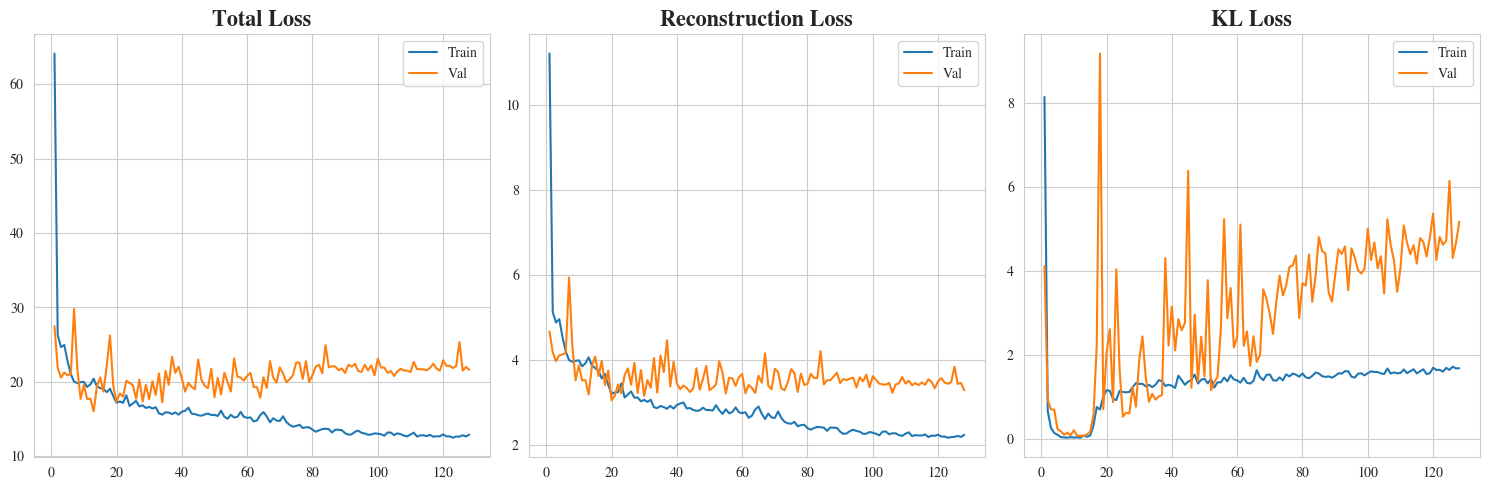

In [340]:
def plot_history(history):
    loss_dict = history.history

    loss_train = loss_dict["loss"]
    loss_val = loss_dict["val_loss"]

    rec_loss = loss_dict["reconstruction_loss"]
    rec_loss_val = loss_dict["val_reconstruction_loss"]

    kl_loss = loss_dict["kl_loss"]
    kl_loss_val = loss_dict["val_kl_loss"]

    x = [i+1 for i in range(0, len(loss_train))]

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    axes[0].set_title("Total Loss", size=16, fontweight="bold")
    sns.lineplot(x=x, y=loss_train, label="Train", ax=axes[0])
    sns.lineplot(x=x, y=loss_val, label="Val", ax=axes[0])

    axes[1].set_title("Reconstruction Loss", size=16, fontweight="bold")
    sns.lineplot(x=x, y=rec_loss, label="Train", ax=axes[1])
    sns.lineplot(x=x, y=rec_loss_val, label="Val", ax=axes[1])

    axes[2].set_title("KL Loss", size=16, fontweight="bold")
    sns.lineplot(x=x, y=kl_loss, label="Train", ax=axes[2])
    sns.lineplot(x=x, y=kl_loss_val, label="Val", ax=axes[2])
    fig.tight_layout()

    if SAVE_MODEL:
        print(f"Saved History in '../models/{MODEL_ID}/assets/'")
        plt.savefig(f"../models/{MODEL_ID}/assets/history.png")


plot_history(history)

# Reconstruction Plotting

In [341]:
SAMPLE_IDX_TO_VISUALIZE: int = 0

train_sample = np.expand_dims(tensor[SAMPLE_IDX_TO_VISUALIZE], axis=0)
train_sample_condition = conditions.iloc[SAMPLE_IDX_TO_VISUALIZE, 0]
print(f"Shape of train_sample to visualize: {train_sample.shape} with condition '{train_sample_condition}'")

Shape of train_sample to visualize: (1, 250, 7) with condition 'MathxHard'


In [342]:
train_sample_reconstructed = vae.predict(train_sample)

1/1 [==============================] - 0s 268ms/step


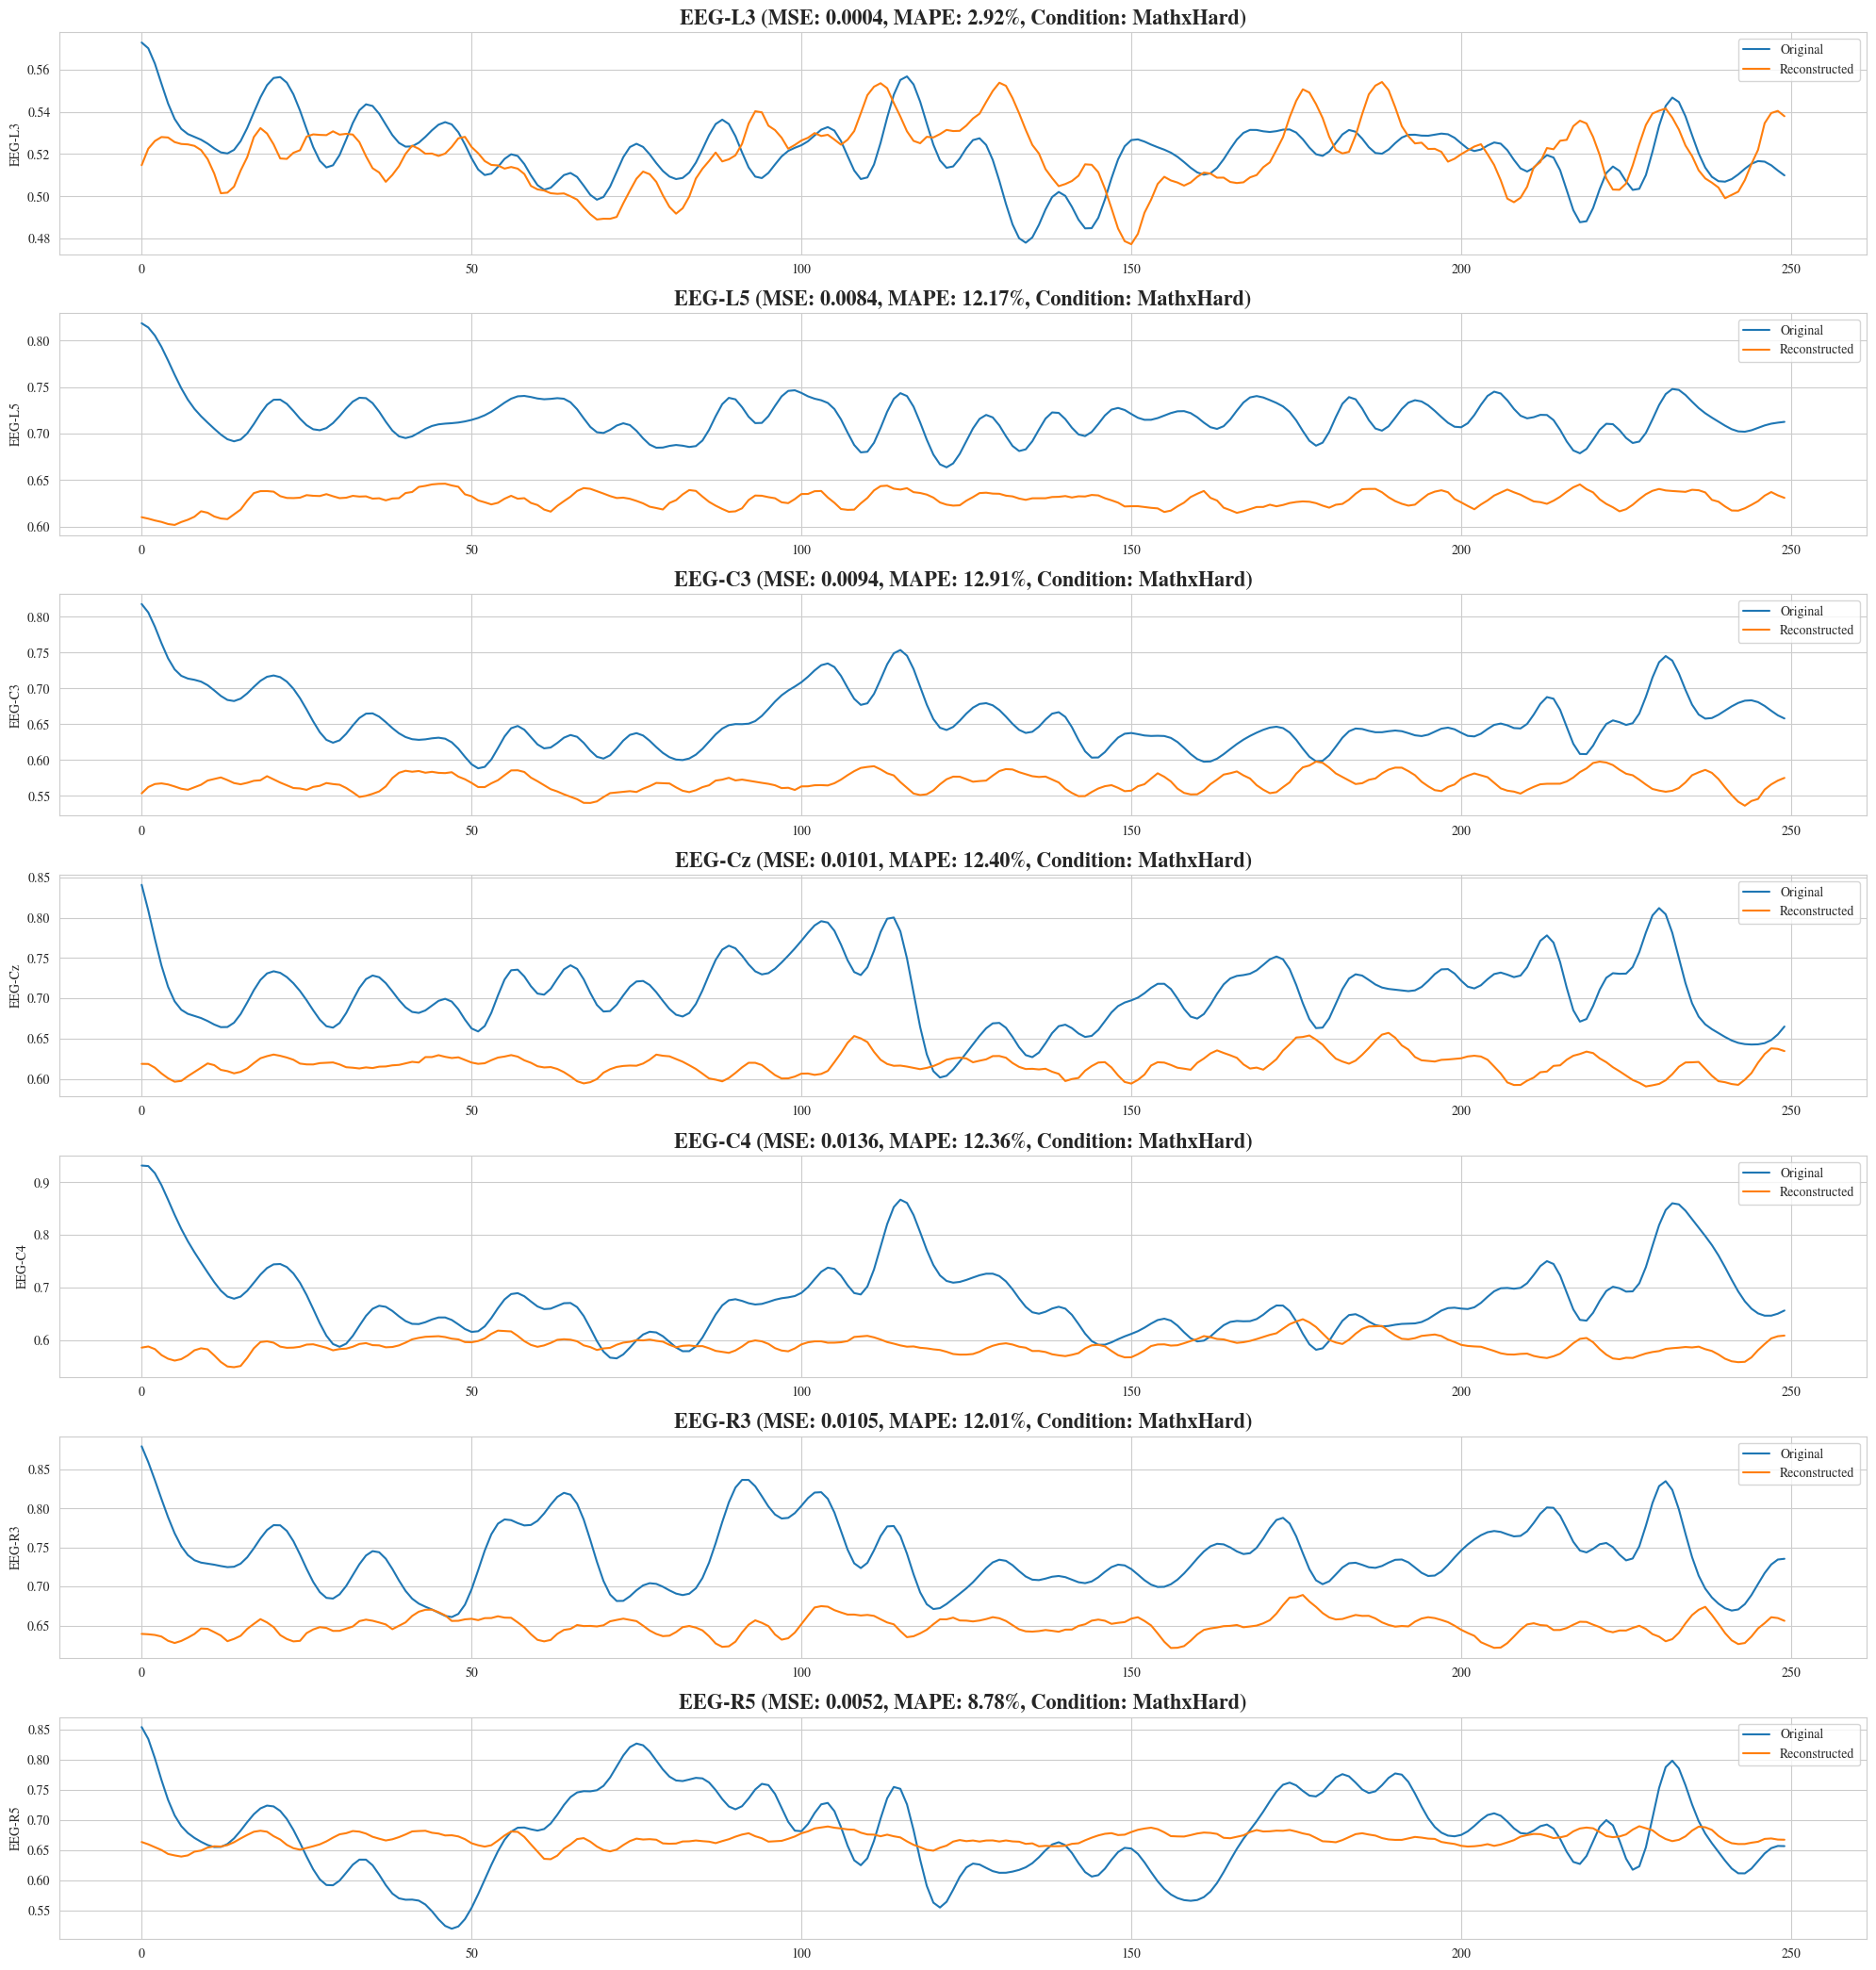

In [343]:
# Compare original and reconstruction
def compare_original_and_reconstruction(sample: np.array, sample_reconstructed: np.array, condition: str) -> None:
    # Compute MSE and MAPE along the rows, for each column
    mse = np.mean(((train_sample[0] - train_sample_reconstructed[0])**2), axis=0)
    mape = np.mean(np.abs((train_sample[0] - train_sample_reconstructed[0]) / train_sample[0]), axis=0) * 100

    # Convert to pd.DataFrame for plotting reasons
    df_sample = pd.DataFrame(sample, columns=FEATURE_NAMES)
    df_reconstructed = pd.DataFrame(sample_reconstructed, columns=FEATURE_NAMES)

    fig, axes = plt.subplots(nrows=len(FEATURE_NAMES), ncols=1, figsize=(20, len(FEATURE_NAMES)*3))
    for i, (col, ax) in enumerate(zip(FEATURE_NAMES, axes.flatten())):
        sns.lineplot(data=df_sample, x=df_sample.index, y=col, ax=ax, label="Original")
        sns.lineplot(data=df_reconstructed, x=df_reconstructed.index, y=col, ax=ax, label="Reconstructed")
        #ax.fill_between(df_reconstructed.index, df_sample[col], df_reconstructed[col], color='lightcoral', label="Error")
        ax.set_title(f"{col} (MSE: {mse[i]:.4f}, MAPE: {mape[i]:.2f}%, Condition: {condition})", fontweight="bold", size=16)
    fig.tight_layout()

    if SAVE_MODEL:
        print(f"Saved Comparison in '../models/{MODEL_ID}/assets/'")
        plt.savefig(f"../models/{MODEL_ID}/assets/comparison.png")


compare_original_and_reconstruction(train_sample[0], train_sample_reconstructed[0], condition=train_sample_condition)

# Generate new Samples by Sampling from latent space

In [344]:
# Generate synthetic data function using the decoder part of the VAE
def generate_time_series_conditioned_on_x(x: np.array, num_samples: int, latent_dims: int):
    # Get mean and log_variance from encoding x
    z_mean, z_log_var, _ = vae.encoder.predict(x)
    # Sample from the latent space
    latent_samples = np.random.normal(size=(num_samples, latent_dims), loc=z_mean, scale=np.exp(z_log_var))
    print(f"Latent Samples: {latent_samples}")
    print("z_mean: ", z_mean)
    print("z_log_Var: ", z_log_var)
    # Generate synthetic data using the decoder model
    synthetic_data = vae.decoder(latent_samples).numpy()
    return synthetic_data

def sample_from_prior_z(num_samples: int, latent_dims: int):
    z = np.random.normal(size=(num_samples, latent_dims))
    return z

def get_samples_given_z(z):
    samples = vae.decoder(z).numpy()
    return samples

# Generate synthetic time series data
num_samples = 1
#synthetic_time_series = generate_time_series_conditioned_on_x(train_sample, num_samples, latent_dims=LATENT_DIM)
synthetic_time_series = get_samples_given_z(sample_from_prior_z(num_samples, LATENT_DIM))
print(synthetic_time_series.shape)

(1, 250, 7)


In [345]:
def plot_all_time_series(X: np.array) -> None:
    """ Plots all Time Series (all float64 columns) in the provided DataFrame

    :param x: np.array -- Input data of shape (N_SEQ, N_FEATS)
    :param time_col: str -- Name of the time column
    :return: None
    """
    df = pd.DataFrame(X, columns=FEATURE_NAMES)

    fig, axes = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(20, len(df.columns)*3))
    for col, ax in zip(df.columns, axes.flatten()):
        sns.lineplot(data=df, x=df.index, y=col, ax=ax)
        ax.set_title(col, fontweight="bold", size=16)
    fig.tight_layout()

#plot_all_time_series(synthetic_time_series[0])

# Visualize latent space / posterior
$$ q_\Phi(z|x) \approx p\theta(z|x) $$

In [346]:
def encode_batch(x: np.array):
    z_mean, z_log_var, z = vae.encoder(x)
    return z_mean, z_log_var, z

z_mean, z_log_var, z = encode_batch(tensor)
z_mean.shape

TensorShape([440, 64])

## Visualize using TSNE

In [347]:
from sklearn.manifold import TSNE

In [348]:
def plot_latent_space_tsne(z_mean) -> None:
    tsne = TSNE(perplexity=30)
    z_dim_reduced = tsne.fit_transform(z_mean)

    fig, ax = plt.subplots(1,1, figsize=(10,7))
    ax.set_title("Dimension reduced z space using T-SNE", fontweight="bold", size=16)
    sns.scatterplot(x=z_dim_reduced[:,0], y=z_dim_reduced[:,1], ax=ax, edgecolor="black", alpha=.8, hue=classes[:, 0])# hue=conditions.values[:,0])
    ax.set_xlabel("z_mean[0]")
    ax.set_ylabel("z_mean[1]")
    fig.show()

In [349]:
#plot_latent_space_tsne(z_mean)

## Visualize using PCA

In [350]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

N_PCS: int = 2
N_CLUSTERS: int = 3
    
pca = PCA(n_components=N_PCS, random_state=42)
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)

In [351]:
z_dim_reduced_pca = pca.fit_transform(z_mean)
labels = kmeans.fit(z_mean).labels_

In [352]:
print(f"Total Explained Variance: {sum(pca.explained_variance_ratio_):.2f}")
pca.explained_variance_ratio_

Total Explained Variance: 0.99


array([0.99068413, 0.00396735])

In [353]:
centroids = pca.transform(kmeans.cluster_centers_)
centroids

array([[ 0.37664143, -0.04601935],
       [-0.94039421,  0.03991259],
       [ 1.93823494,  0.06654038]])

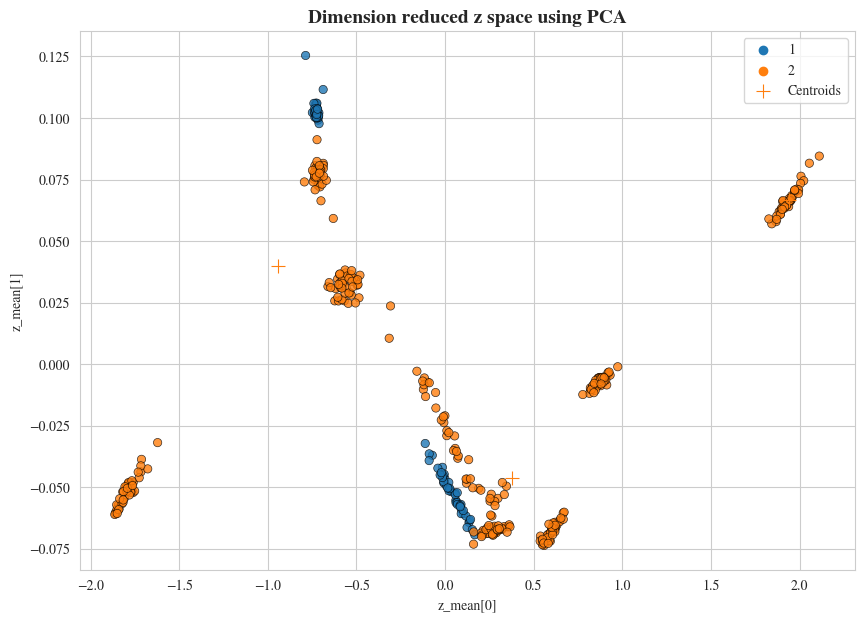

In [354]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.set_title("Dimension reduced z space using PCA", fontweight="bold", size=14)
sns.scatterplot(x=z_dim_reduced_pca[:,0], y=z_dim_reduced_pca[:,1], ax=ax, edgecolor="black", alpha=.8, hue=classes[:,0], palette="tab10")
sns.scatterplot(x=centroids[:,0], y=centroids[:, 1], marker="+", label="Centroids", s=100, edgecolor="black")
ax.set_xlabel("z_mean[0]")
ax.set_ylabel("z_mean[1]")
fig.show()

In [355]:
# Pick a Sample and recounstruct
sample_z_mean = np.array([[0, 0]])
sample_z_mean = pca.inverse_transform(sample_z_mean)

In [356]:
sample_z_mean_reconstructed = vae.decoder(sample_z_mean)

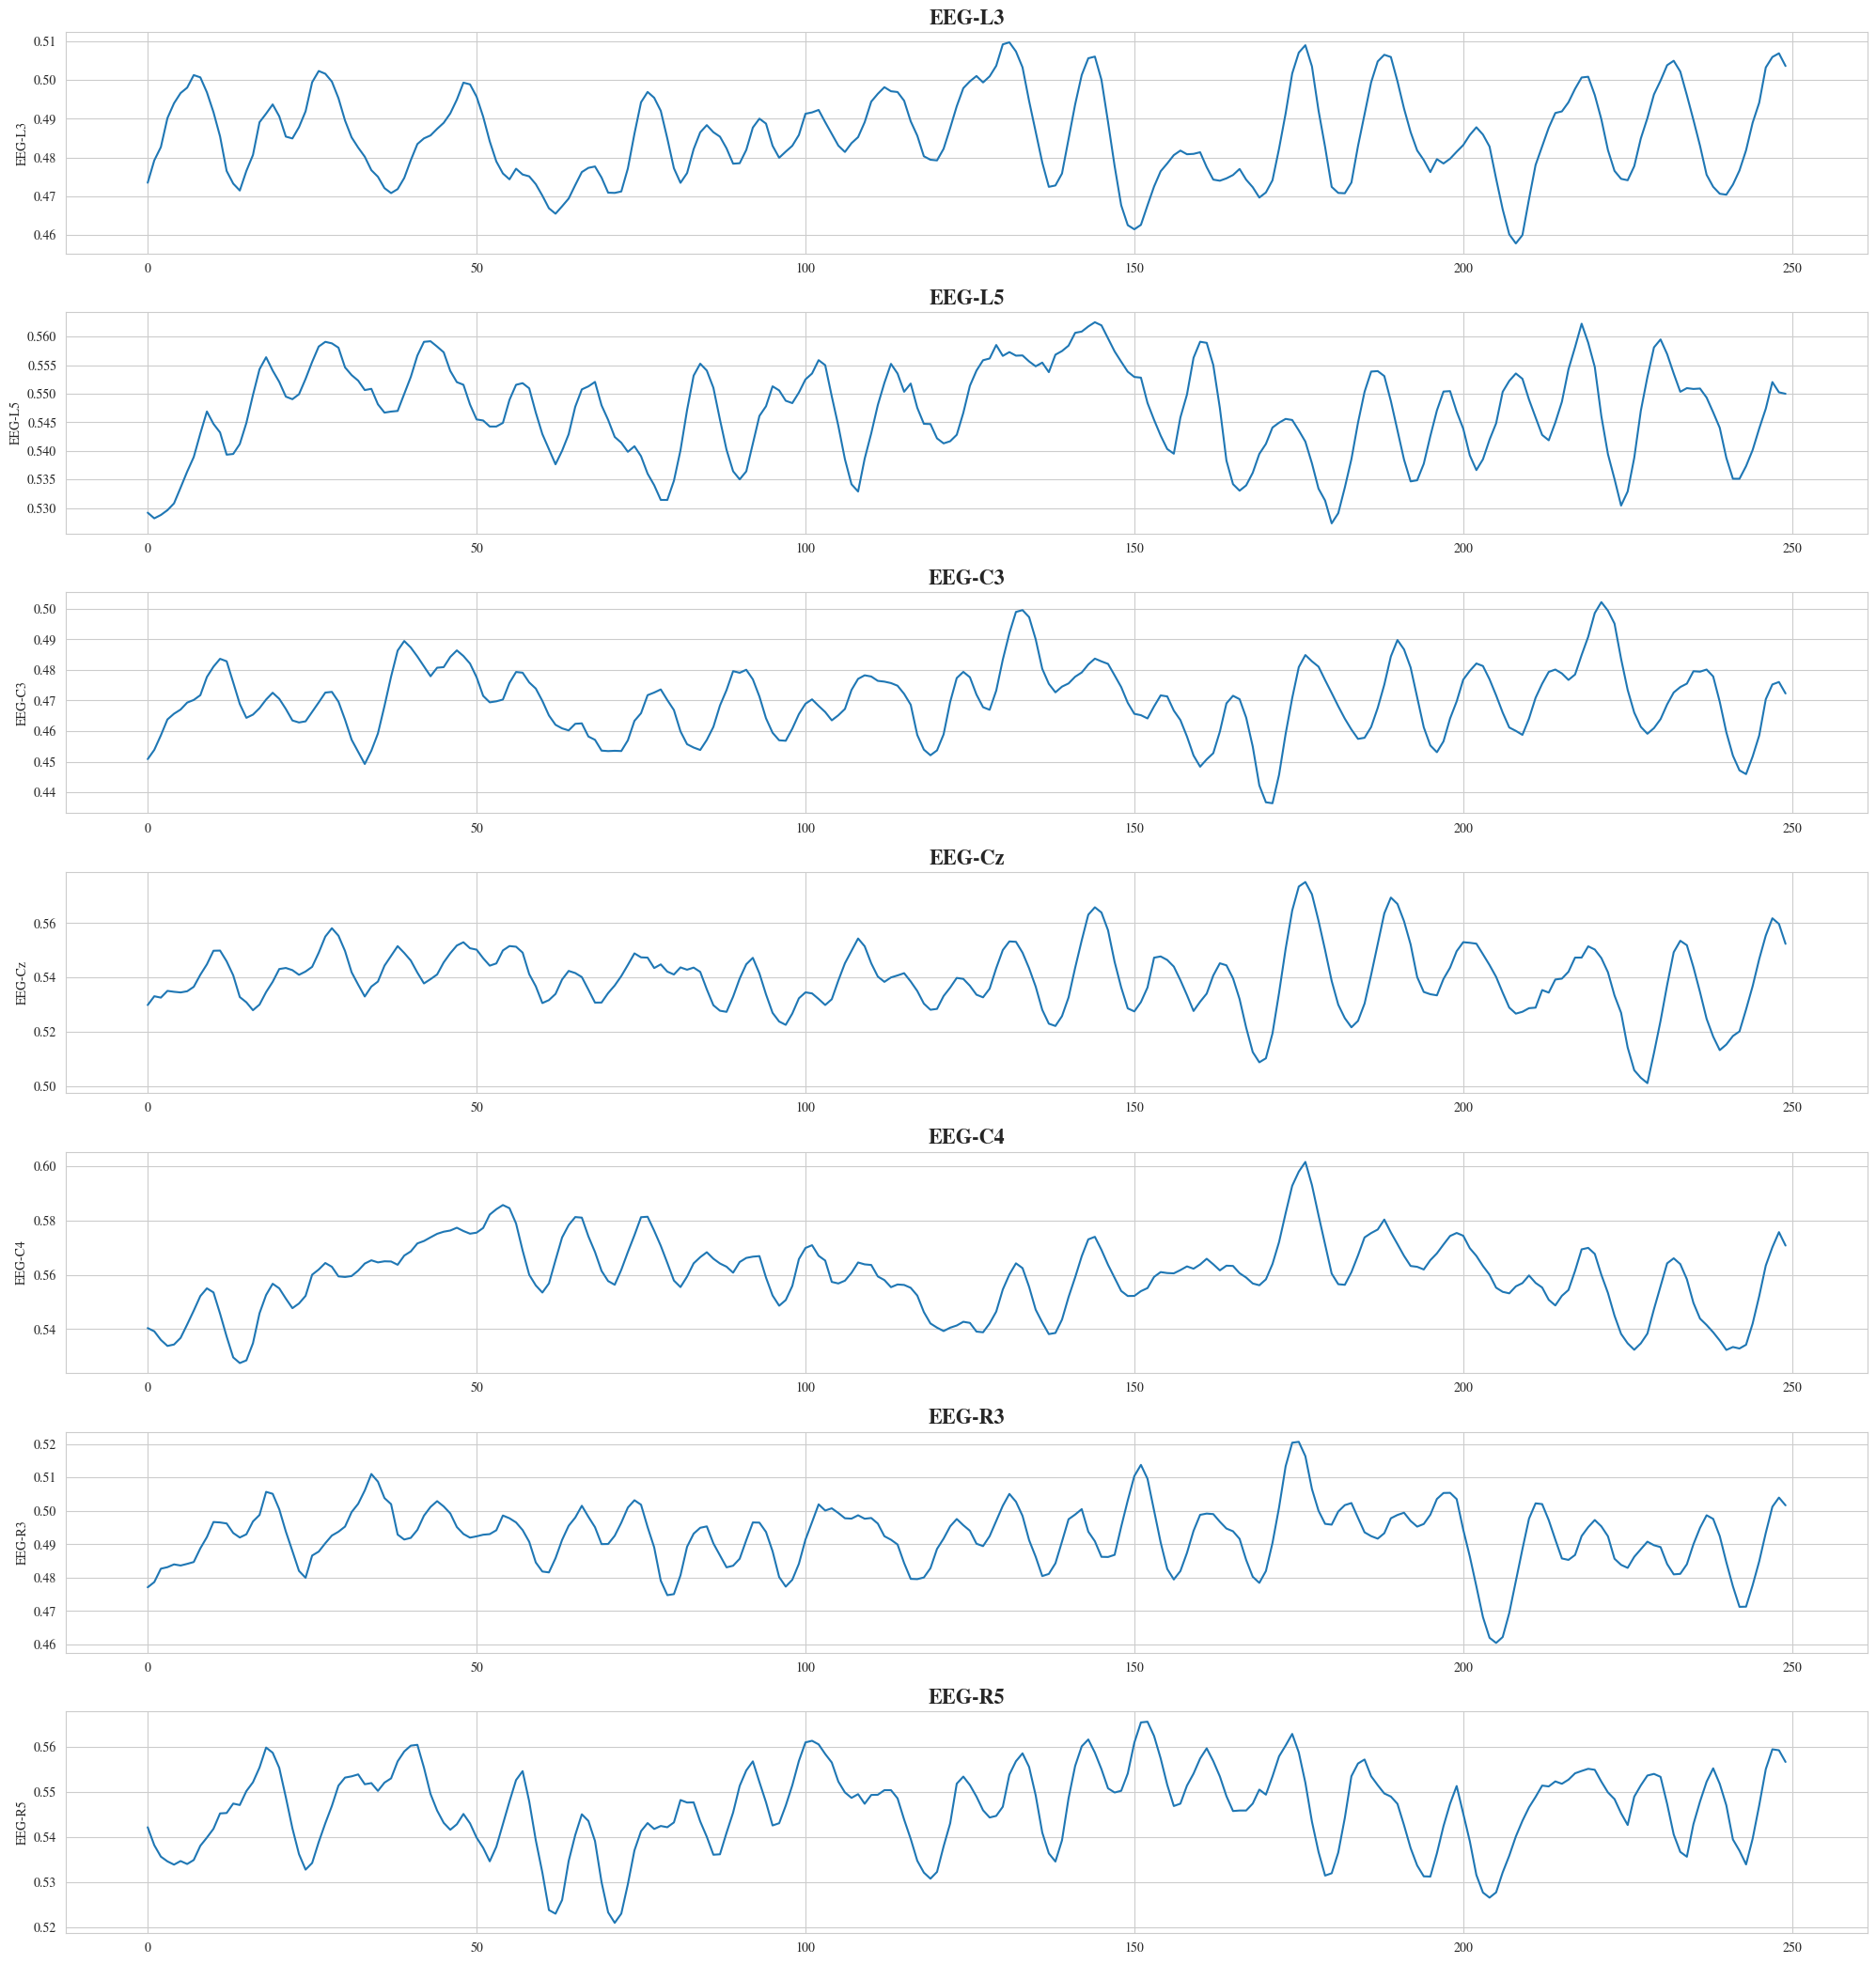

In [357]:
plot_all_time_series(sample_z_mean_reconstructed[0])

## Visualize Clusters

In [358]:
centroid_reconstructed = pca.inverse_transform(centroids)

In [359]:
samples_from_centroids = vae.decoder(centroid_reconstructed)

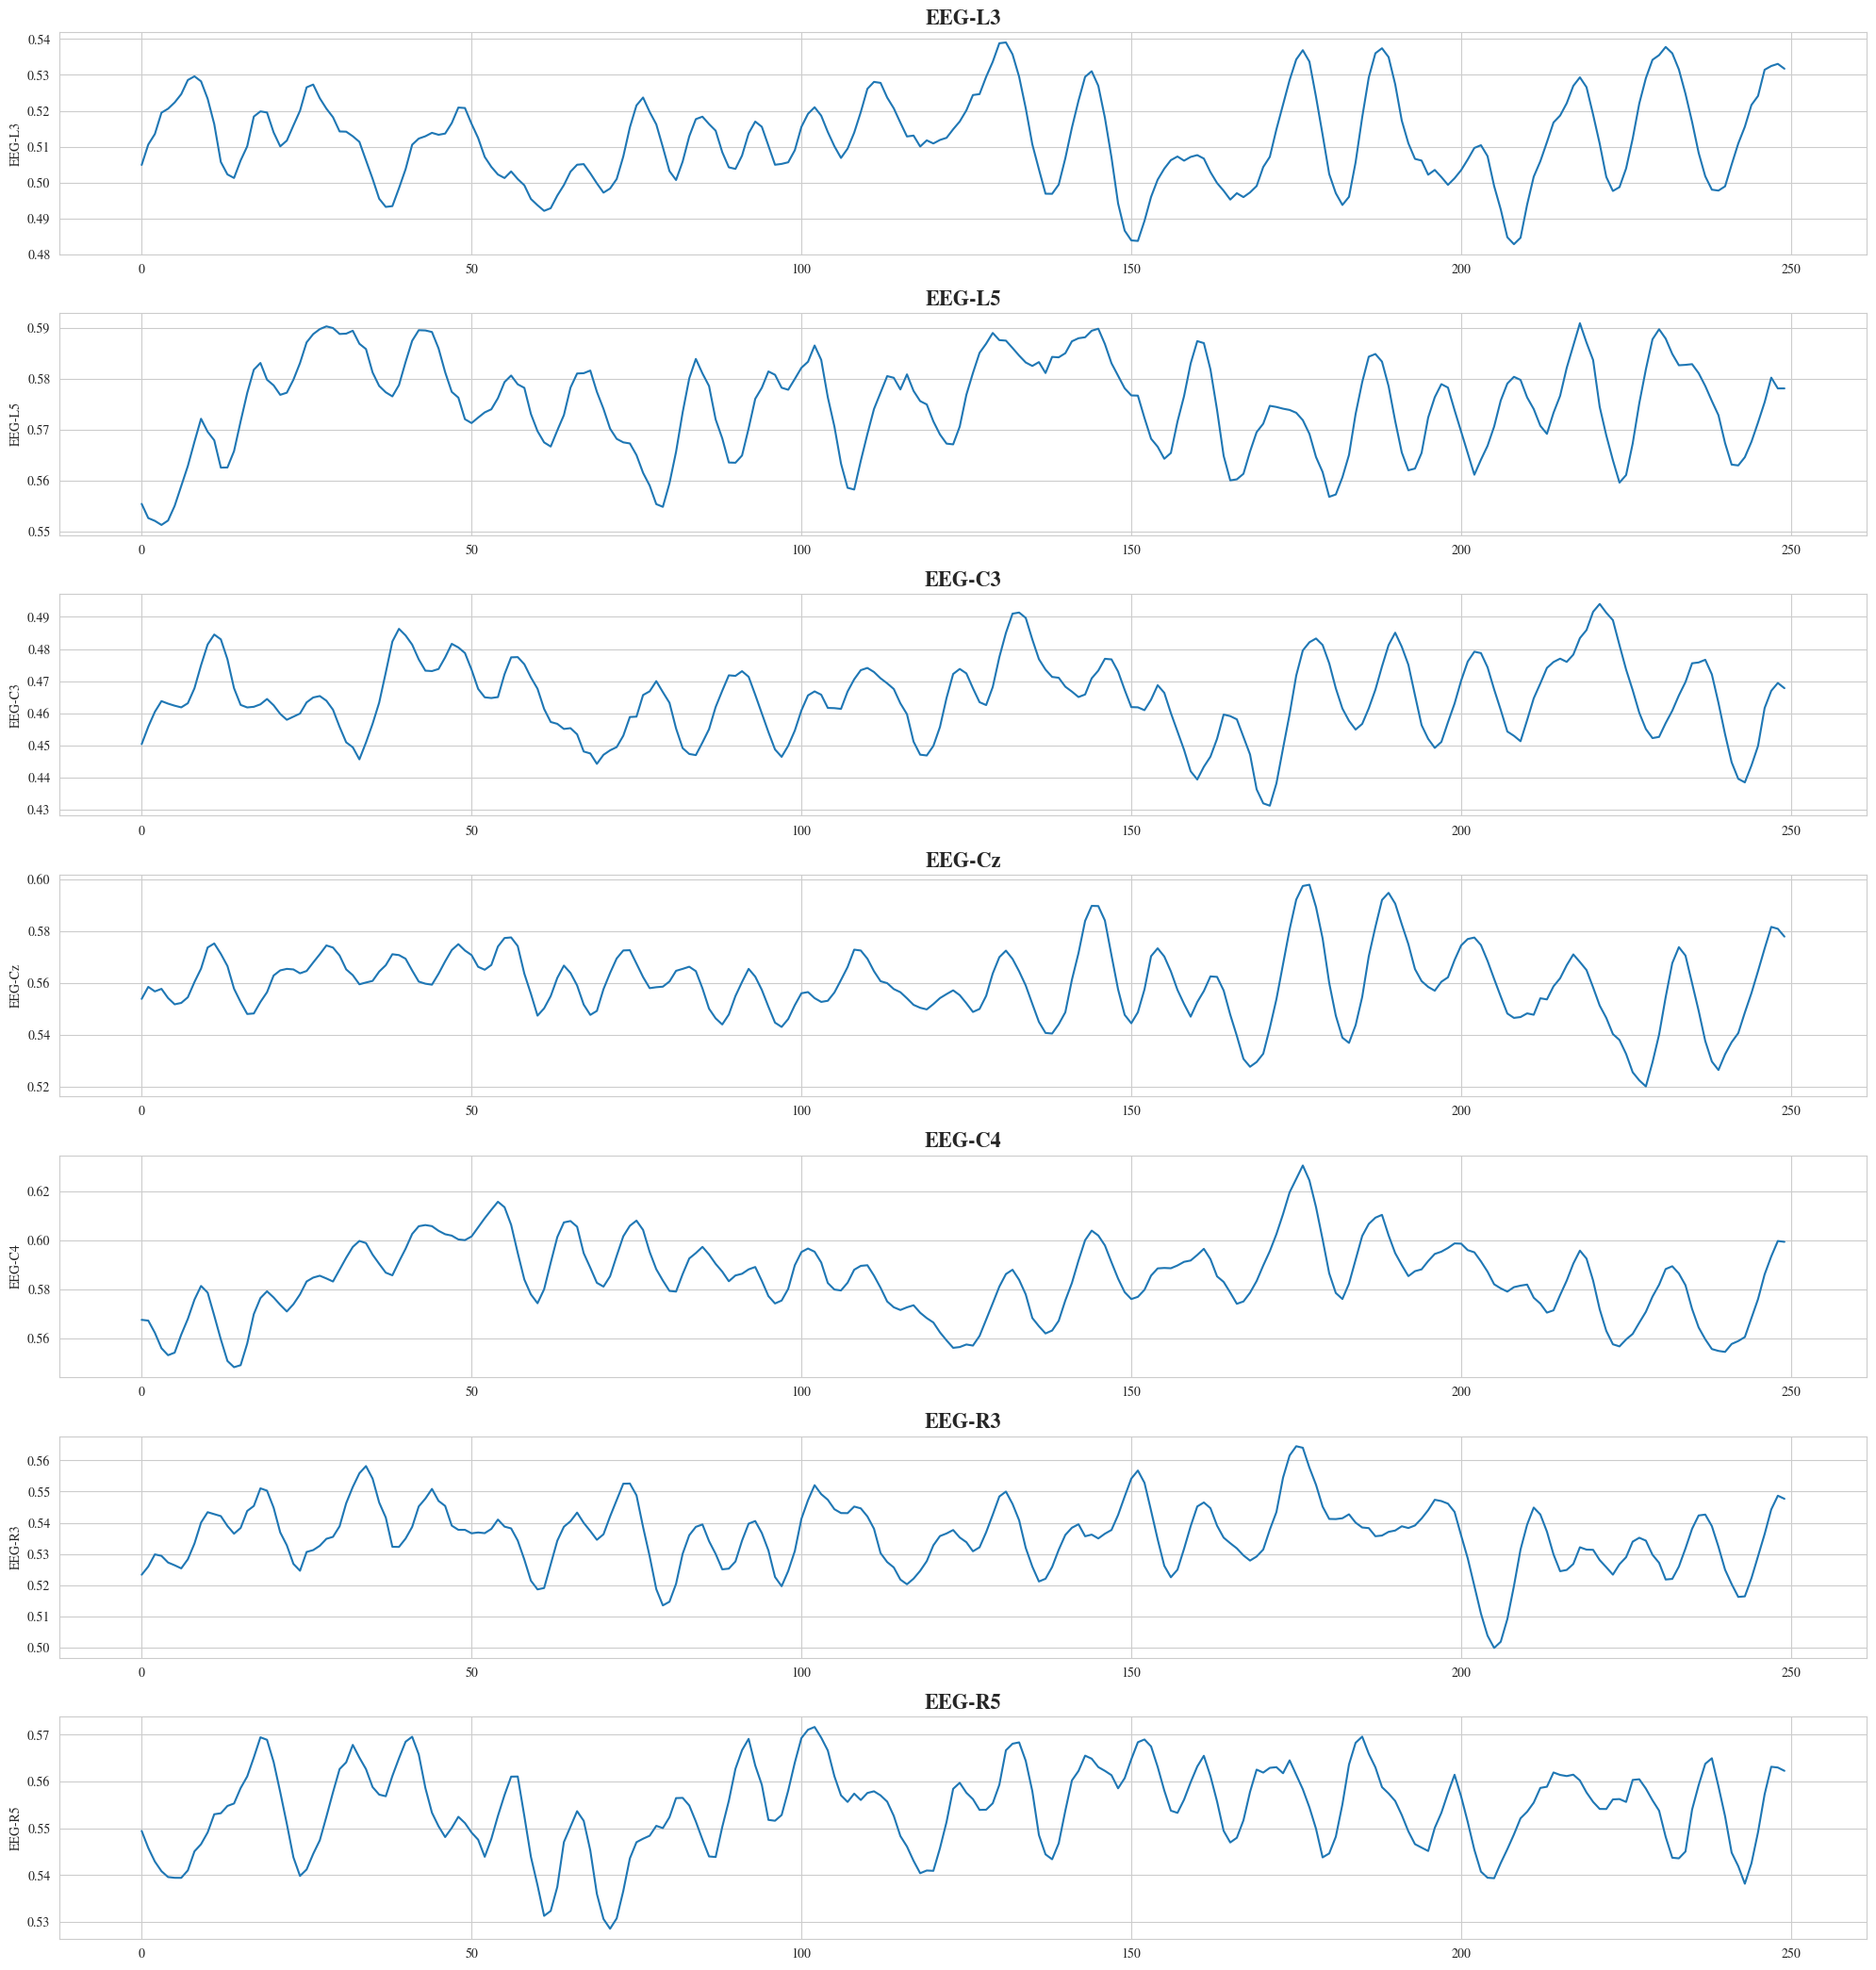

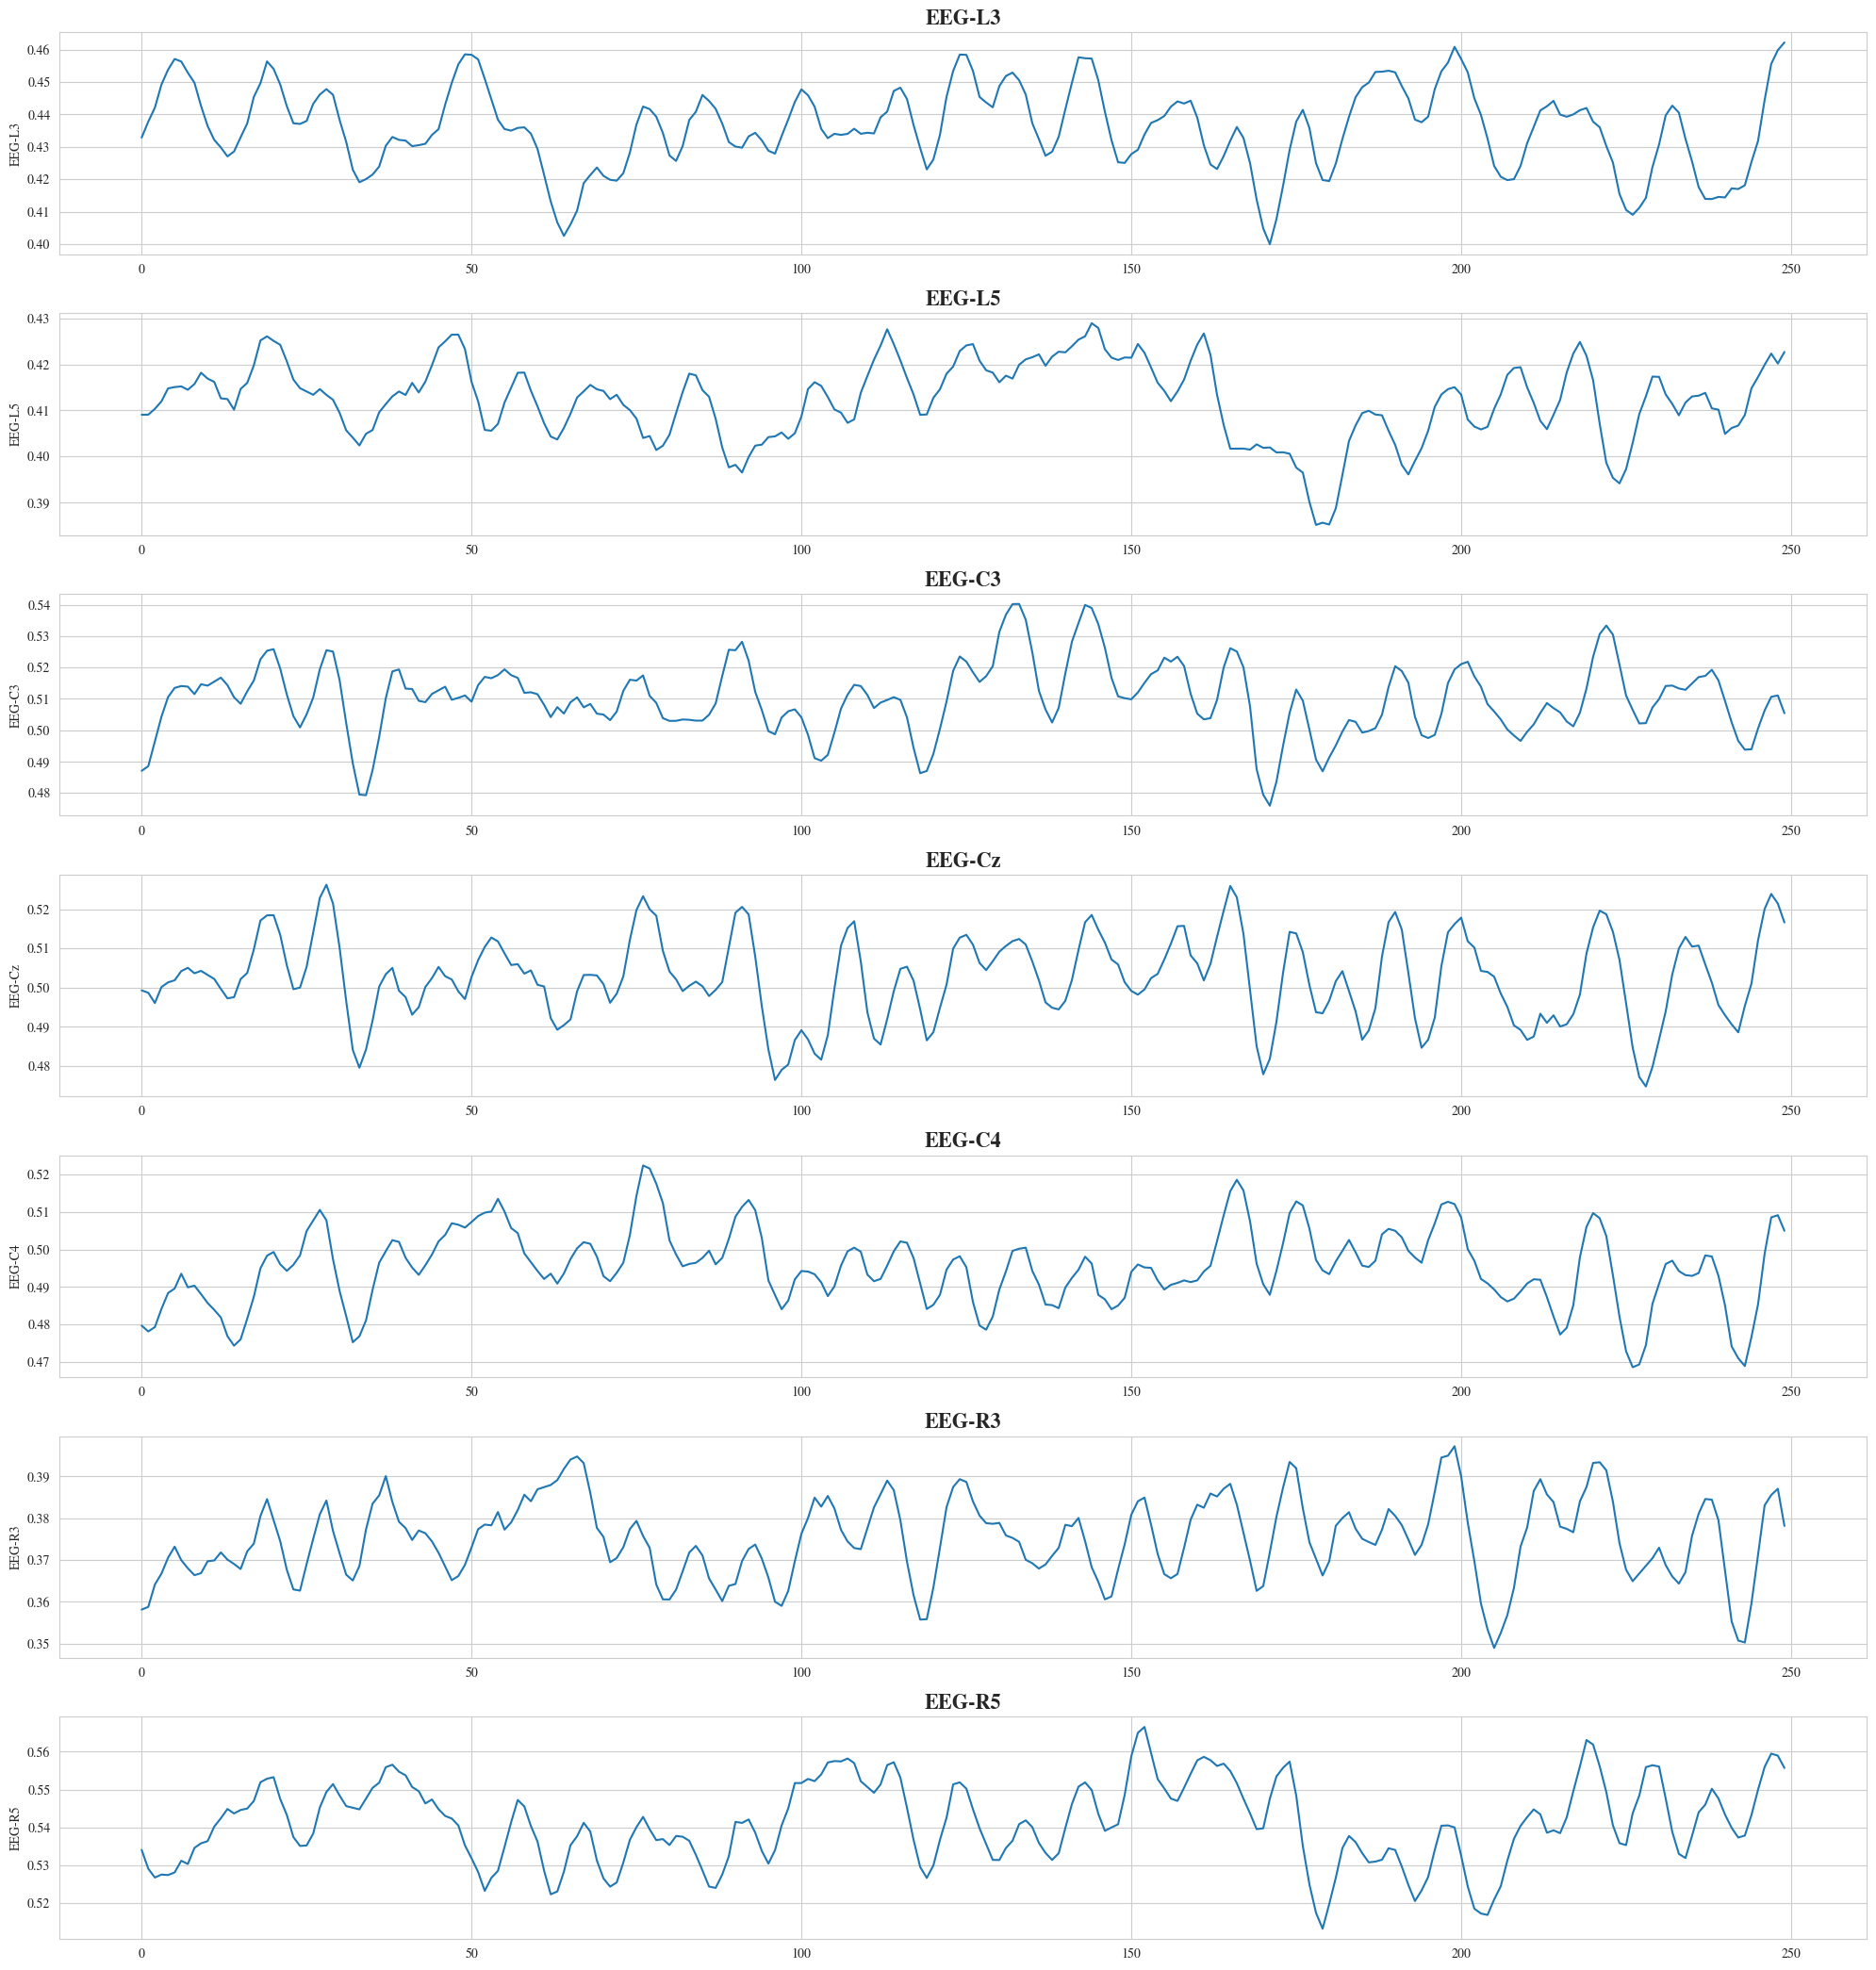

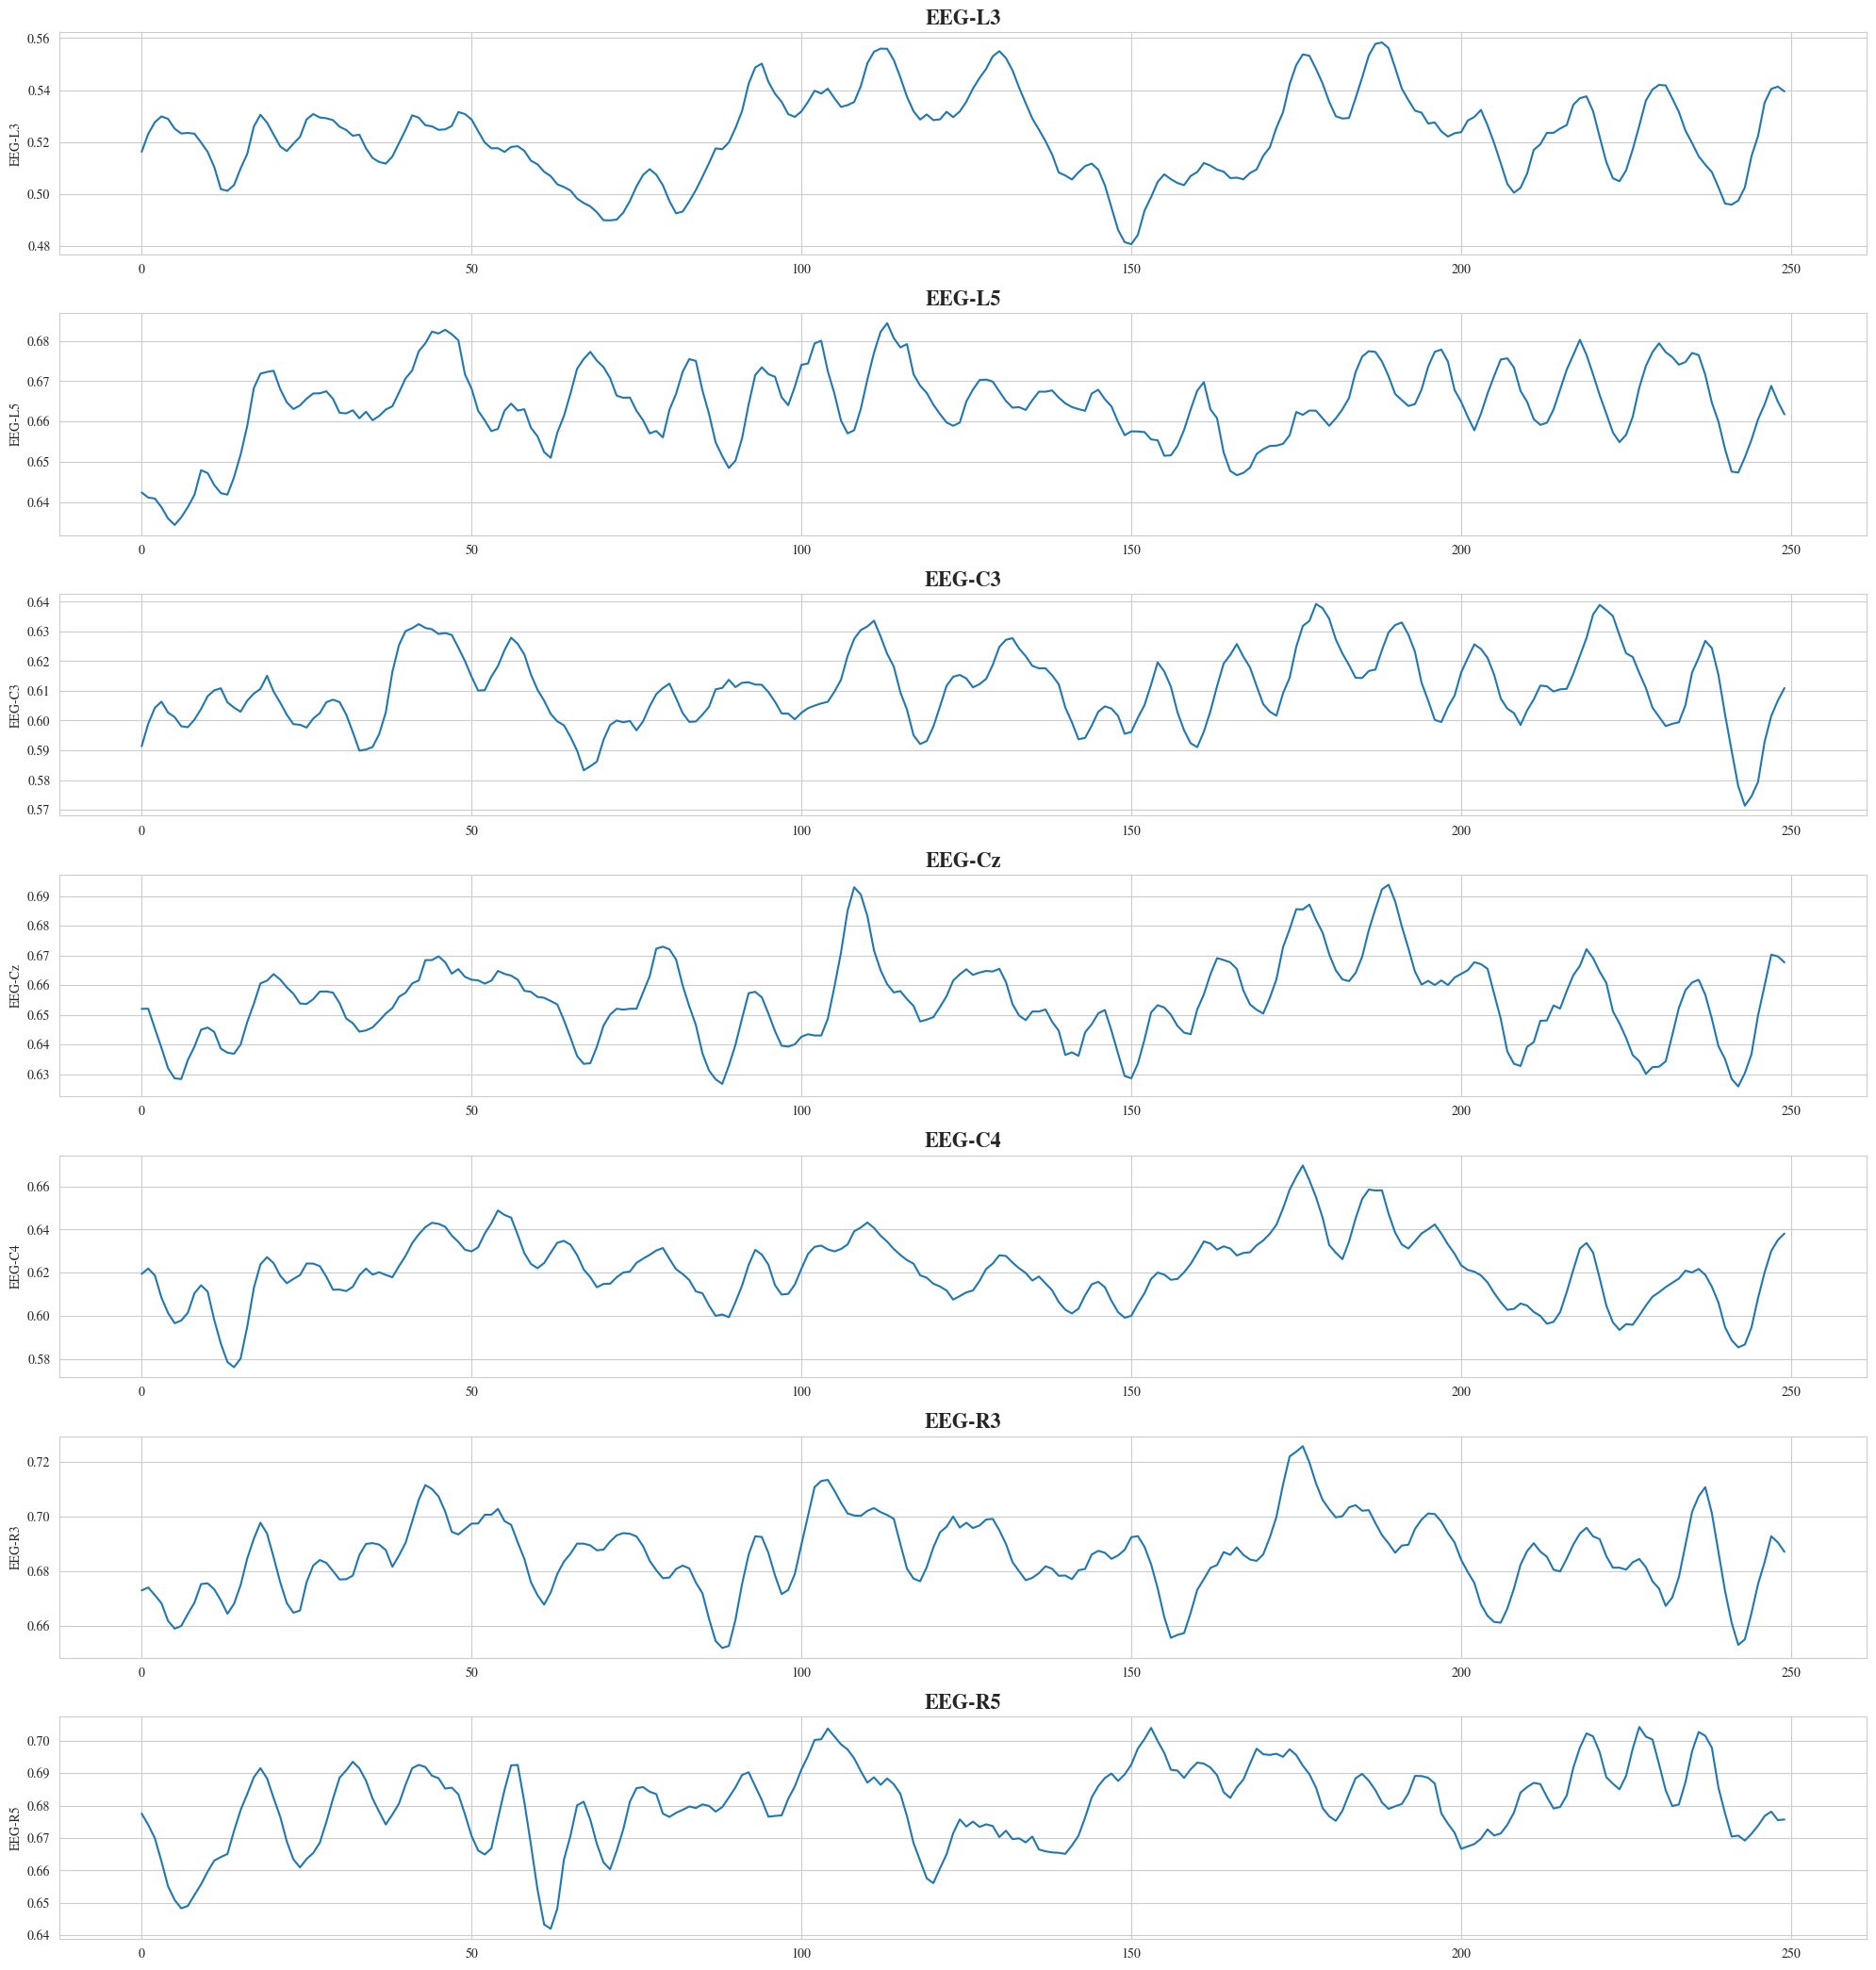

In [360]:
for i in range(samples_from_centroids.shape[0]):
    plot_all_time_series(samples_from_centroids[i])